This notebook processes JSON files generated at `data/` to assess the coverage of Confidence Intervals.

In [1]:
import pandas as pd
import numpy as np
import json
from glob import glob
import altair as vg
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.DataFrame([json.load(open(fname, 'rt')) for fname in glob('data/*')])

In [3]:
data.head()

,trial,folds,gini,nobs,p,gini_folds,gini_out
0,13.0,5,0.65,7000,0.08,"[0.34959349593495936, 0.8906525573192239, 0.82...",0.645109
1,43.0,40,0.65,5000,0.08,"[0.9406779661016949, 0.7540983606557377, 0.672...",0.642146
2,253.0,10,0.65,111000,0.08,"[0.6057386894434806, 0.6453995471922205, 0.635...",0.649338
3,922.0,10,0.65,81000,0.08,"[0.6721779499019389, 0.6557073954983923, 0.650...",0.647431
4,686.0,10,0.65,141000,0.08,"[0.6751964085297417, 0.654917729779481, 0.6143...",0.647775


In [4]:
sdata = data.query('gini == 0.65 and folds == 10 and p == 0.08')
sdata.head()

,trial,folds,gini,nobs,p,gini_folds,gini_out
2,253.0,10,0.65,111000,0.08,"[0.6057386894434806, 0.6453995471922205, 0.635...",0.649338
3,922.0,10,0.65,81000,0.08,"[0.6721779499019389, 0.6557073954983923, 0.650...",0.647431
4,686.0,10,0.65,141000,0.08,"[0.6751964085297417, 0.654917729779481, 0.6143...",0.647775
6,59.0,10,0.65,10000,0.08,"[0.31034482758620685, 0.6647509578544062, 0.59...",0.645709
9,717.0,10,0.65,1000,0.08,"[0.3333333333333335, 1.0, 1.0, 0, 0.2727272727...",0.666341


In [5]:
rs = scipy.stats._bootstrap._bootstrap_resample(
    np.array([1,2,3,4,5,6,7,8,9,10]),
    n_resamples=5,
)
rs.mean(axis=1)

array([4.9, 4.3, 5.3, 5.8, 6.9])

In [55]:
def evaluate(z=1.96):

    def nci(x):
        m = np.mean(x)
        err = np.std(x) * z / np.sqrt(len(x))
        return (m-err, m+err)

    def ci(x):
        m = np.mean(x)
        samples = scipy.stats._bootstrap._bootstrap_resample(
            np.array(x),
            n_resamples=1000,
        )
        mm = samples.mean(axis=1)
        v = np.var(mm, ddof=1)
        err = z * np.sqrt(v)
        return (m-err, m+err)

    def isin(row):
        low, high = ci(row['gini_folds'])
        g = row['gini_out']
        return g > low and g < high 

    def nisin(row):
        low, high = nci(row['gini_folds'])
        g = row['gini_out']
        return g > low and g < high 


    bv_ci = sdata.groupby('nobs').apply(lambda x: x.apply(isin, axis=1).sum() / len(x))
    norm_ci = sdata.groupby('nobs').apply(lambda x: x.apply(nisin, axis=1).sum() / len(x))
    r = pd.concat([bv_ci, norm_ci], axis=1)
    r.columns = ['bv', 'norm']
    mr = pd.melt(r)
    mr['z'] = z
    return mr

In [23]:
ppfs = [scipy.stats.norm().cdf(x) for x in np.arange(1, 4.5, .05)]

results = [
    evaluate(z=scipy.stats.norm().ppf(ppf))
    for ppf in ppfs
]    

In [51]:
def summary(x):
    cov = x# ['value']
    err = np.std(cov) * 2.57 / len(cov)
    m = np.mean(cov)
    return dict(mean=m, min=m-err, max=m+err)

pr = (
    pd.concat(results)
    .groupby(['variable', 'z'])
    .agg(summary=('value', summary))
    .reset_index()
)
pr = (
    pd.concat(
        [
            pr.drop('summary', axis=1),
            pr.apply(lambda x: x['summary'], result_type='expand', axis=1)
        ],
        axis=1
    )
)
pr

,variable,z,mean,min,max
0,bv,1.00,0.577125,0.571132,0.583118
1,bv,1.05,0.597929,0.591718,0.604141
2,bv,1.10,0.623249,0.616998,0.629500
3,bv,1.15,0.643458,0.637301,0.649614
4,bv,1.20,0.661475,0.655145,0.667805
...,...,...,...,...,...
135,norm,4.25,0.994634,0.994039,0.995229
136,norm,4.30,0.995101,0.994505,0.995698
137,norm,4.35,0.995234,0.994663,0.995806
138,norm,4.40,0.995401,0.994861,0.995941


In [54]:
base = vg.Chart(pr).encode(
    vg.X('z:Q'), 
    vg.Color('variable:N'),
)
lines = base.mark_line().encode(
    vg.Y('mean:Q'),
).interactive(bind_x=False)
bands = base.mark_area(opacity=0.2).encode(
    vg.Y('min:Q'),
    vg.Y2('max:Q'),
).interactive(bind_x=False)
lines + bands

alt.LayerChart(...)

In [56]:
pdata = data.query('gini == 0.65 and folds == 10 and p == 0.08 and nobs == 11000')
pdata.head()

,trial,folds,gini,nobs,p,gini_folds,gini_out
19,58.0,10,0.65,11000,0.08,"[0.242586290714633, 0.891195418754474, 0.40730...",0.655973
61,715.0,10,0.65,11000,0.08,"[0.7553832902670112, 0.521832498210451, 0.6129...",0.659936
110,545.0,10,0.65,11000,0.08,"[0.5489417989417988, 0.8134615384615385, 0.681...",0.647770
114,435.0,10,0.65,11000,0.08,"[0.7384615384615383, 0.5702764976958523, 0.449...",0.652778
169,117.0,10,0.65,11000,0.08,"[0.6607015032211883, 0.41292307692307695, 0.54...",0.655563


In [57]:
scipy.stats.beta.fit(pdata['gini_out'])

(12.499467415811825,
 15.540739127968187,
 0.6227672284213113,
 0.05782993970969058)

In [58]:
a, b, loc, scale = scipy.stats.beta.fit(pdata['gini_out'])

/tmp/ipykernel_584712/3596424362.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p, 'k', linewidth=2, c='red')


Text(0.5, 1.0, 'Fit results: mu = 0.65,  std = 0.01')

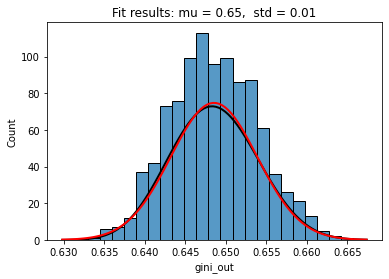

In [59]:
sns.histplot(pdata['gini_out'])

mu, std = scipy.stats.norm.fit(pdata['gini_out'])

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.beta.pdf(x, a, b, loc=loc, scale=scale)
plt.plot(x, p, 'k', linewidth=2)
p = scipy.stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, c='red')
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)